## Data Preparation

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load data
df = pd.read_csv('Alcohol_Sales.csv', index_col=0, parse_dates=True)

df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [22]:
df = df.rename({'S4248SM144NCEN': "Sales"}, axis=1)
data = df['Sales'].values
data

array([ 3459,  3458,  4002,  4564,  4221,  4529,  4466,  4137,  4126,
        4259,  4240,  4936,  3031,  3261,  4160,  4377,  4307,  4696,
        4458,  4457,  4364,  4236,  4500,  4974,  3075,  3377,  4443,
        4261,  4460,  4985,  4324,  4719,  4374,  4248,  4784,  4971,
        3370,  3484,  4269,  3994,  4715,  4974,  4223,  5000,  4235,
        4554,  4851,  4826,  3699,  3983,  4262,  4619,  5219,  4836,
        4941,  5062,  4365,  5012,  4850,  5097,  3758,  3825,  4454,
        4635,  5210,  5057,  5231,  5034,  4970,  5342,  4831,  5965,
        3796,  4019,  4898,  5090,  5237,  5447,  5435,  5107,  5515,
        5583,  5346,  6286,  4032,  4435,  5479,  5483,  5587,  6176,
        5621,  5889,  5828,  5849,  6180,  6771,  4243,  4952,  6008,
        5353,  6435,  6673,  5636,  6630,  5887,  6322,  6520,  6678,
        5082,  5216,  5893,  5894,  6799,  6667,  6374,  6840,  5575,
        6545,  6789,  7180,  5117,  5442,  6337,  6525,  7216,  6761,
        6958,  7070,

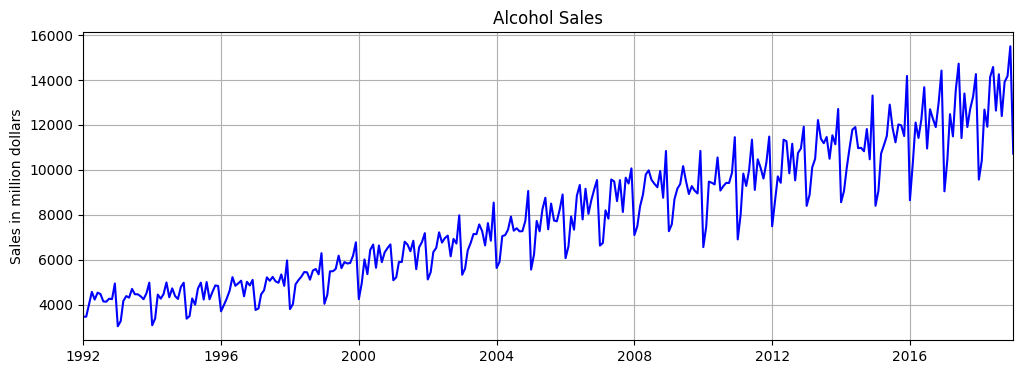

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis= 'x', tight=True)
plt.plot(df['Sales'], color='blue')
plt.show()

In [5]:
# Normalize data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [6]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 12  # Adjust as needed
X, y = create_sequences(data_normalized, seq_length)

In [7]:
X

array([[[0.03431412],
        [0.03423395],
        [0.07784815],
        ...,
        [0.09845266],
        [0.09692937],
        [0.1527299 ]],

       [[0.03423395],
        [0.07784815],
        [0.12290548],
        ...,
        [0.09692937],
        [0.1527299 ],
        [0.        ]],

       [[0.07784815],
        [0.12290548],
        [0.09540608],
        ...,
        [0.1527299 ],
        [0.        ],
        [0.01843983]],

       ...,

       [[0.82017157],
        [0.90066544],
        [0.52377135],
        ...,
        [0.90002405],
        [0.75082178],
        [0.87252465]],

       [[0.90066544],
        [0.52377135],
        [0.59199872],
        ...,
        [0.75082178],
        [0.87252465],
        [0.89336968]],

       [[0.52377135],
        [0.59199872],
        [0.77383148],
        ...,
        [0.87252465],
        [0.89336968],
        [1.        ]]])

In [8]:
# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Create DataLoaders
train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Define the LSTM Model

In [9]:
import torch.nn as nn

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(BidirectionalLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Set Up Training Functions

In [10]:
import torch.optim as optim

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Implement Grid Search

In [13]:
import torch.optim as optim
from itertools import product

def grid_search(param_grid, train_loader, val_loader):
    best_loss = float('inf')
    best_params = None
    best_model = None

    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        
        # Separate model params from training params
        model_params = {k: v for k, v in param_dict.items() if k in ['hidden_size', 'num_layers', 'dropout']}
        
        model = BidirectionalLSTM(input_size=1, output_size=1, **model_params)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=param_dict['learning_rate'])

        print(f"\nTraining with parameters: {param_dict}")
        for epoch in range(param_dict['epochs']):
            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_loss = evaluate(model, val_loader, criterion)
            print(f"Epoch: {epoch+1:3d} Train Loss: {train_loss:.8f} Val Loss: {val_loss:.8f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = param_dict
            best_model = model

    return best_model, best_params, best_loss

# Define parameter grid (this can remain the same)
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'dropout': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'epochs': [50, 100]
}

# Model Training and Evaluation

In [14]:
# Perform grid search
best_model, best_params, best_loss = grid_search(param_grid, train_loader, val_loader)

print("Best Parameters:", best_params)
print("Best Validation Loss:", best_loss)

# Evaluate on test set
test_loss = evaluate(best_model, test_loader, nn.MSELoss())
print("Test Loss:", test_loss)

/Users/youweicheng/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



Training with parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.1, 'learning_rate': 0.001, 'epochs': 50}
Epoch:   1 Train Loss: 0.25629812 Val Loss: 0.24562234
Epoch:   2 Train Loss: 0.21048800 Val Loss: 0.18312832
Epoch:   3 Train Loss: 0.14579746 Val Loss: 0.11622709
Epoch:   4 Train Loss: 0.08791854 Val Loss: 0.04909542
Epoch:   5 Train Loss: 0.04927302 Val Loss: 0.03403086
Epoch:   6 Train Loss: 0.05237372 Val Loss: 0.02783000
Epoch:   7 Train Loss: 0.04098560 Val Loss: 0.03028478
Epoch:   8 Train Loss: 0.04256937 Val Loss: 0.02746889
Epoch:   9 Train Loss: 0.03772277 Val Loss: 0.02330957
Epoch:  10 Train Loss: 0.03410881 Val Loss: 0.02192595
Epoch:  11 Train Loss: 0.03147709 Val Loss: 0.02073816
Epoch:  12 Train Loss: 0.02861329 Val Loss: 0.01865473
Epoch:  13 Train Loss: 0.02538752 Val Loss: 0.01593394
Epoch:  14 Train Loss: 0.02156454 Val Loss: 0.01394224
Epoch:  15 Train Loss: 0.01829676 Val Loss: 0.01188780
Epoch:  16 Train Loss: 0.01395893 Val Loss: 0.00981789
Ep

/Users/youweicheng/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   1 Train Loss: 0.31441986 Val Loss: 0.27563995
Epoch:   2 Train Loss: 0.23470065 Val Loss: 0.21884060
Epoch:   3 Train Loss: 0.18998138 Val Loss: 0.16851143
Epoch:   4 Train Loss: 0.15611936 Val Loss: 0.12035664
Epoch:   5 Train Loss: 0.09802693 Val Loss: 0.07282841
Epoch:   6 Train Loss: 0.06818944 Val Loss: 0.03460341
Epoch:   7 Train Loss: 0.04774302 Val Loss: 0.03011035
Epoch:   8 Train Loss: 0.04347950 Val Loss: 0.02602463
Epoch:   9 Train Loss: 0.03789772 Val Loss: 0.02561631
Epoch:  10 Train Loss: 0.03747353 Val Loss: 0.02501140
Epoch:  11 Train Loss: 0.03151300 Val Loss: 0.02042644
Epoch:  12 Train Loss: 0.02689370 Val Loss: 0.01732131
Epoch:  13 Train Loss: 0.02572307 Val Loss: 0.01457425
Epoch:  14 Train Loss: 0.01683787 Val Loss: 0.01183580
Epoch:  15 Train Loss: 0.01583252 Val Loss: 0.00880186
Epoch:  16 Train Loss: 0.00945811 Val Loss: 0.00807188
Epoch:  17 Train Loss: 0.00976369 Val Loss: 0.00887556
Epoch:  18 Train Loss: 0.01192591 Val Loss: 0.00891729
Epoch:  19

/Users/youweicheng/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   4 Train Loss: 0.05144557 Val Loss: 0.03333995
Epoch:   5 Train Loss: 0.05046711 Val Loss: 0.03174908
Epoch:   6 Train Loss: 0.05391156 Val Loss: 0.03080651
Epoch:   7 Train Loss: 0.04428026 Val Loss: 0.02967446
Epoch:   8 Train Loss: 0.04779601 Val Loss: 0.02779605
Epoch:   9 Train Loss: 0.04027848 Val Loss: 0.02484467
Epoch:  10 Train Loss: 0.03548531 Val Loss: 0.02214553
Epoch:  11 Train Loss: 0.03059498 Val Loss: 0.01882024
Epoch:  12 Train Loss: 0.02539674 Val Loss: 0.01504025
Epoch:  13 Train Loss: 0.01895746 Val Loss: 0.01047788
Epoch:  14 Train Loss: 0.01075947 Val Loss: 0.00926351
Epoch:  15 Train Loss: 0.00894489 Val Loss: 0.01032502
Epoch:  16 Train Loss: 0.01169965 Val Loss: 0.00866961
Epoch:  17 Train Loss: 0.00969311 Val Loss: 0.00829514
Epoch:  18 Train Loss: 0.01280334 Val Loss: 0.00984709
Epoch:  19 Train Loss: 0.01081855 Val Loss: 0.00860609
Epoch:  20 Train Loss: 0.00897076 Val Loss: 0.00811641
Epoch:  21 Train Loss: 0.00884531 Val Loss: 0.00842992
Epoch:  22

/Users/youweicheng/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   1 Train Loss: 0.14298814 Val Loss: 0.12681666
Epoch:   2 Train Loss: 0.10623187 Val Loss: 0.08582983
Epoch:   3 Train Loss: 0.08471750 Val Loss: 0.05084714
Epoch:   4 Train Loss: 0.05274312 Val Loss: 0.02977285
Epoch:   5 Train Loss: 0.05094830 Val Loss: 0.02765530
Epoch:   6 Train Loss: 0.04556833 Val Loss: 0.02532146
Epoch:   7 Train Loss: 0.04570041 Val Loss: 0.02455909
Epoch:   8 Train Loss: 0.03653668 Val Loss: 0.02130357
Epoch:   9 Train Loss: 0.02975207 Val Loss: 0.01833079
Epoch:  10 Train Loss: 0.02779284 Val Loss: 0.01562217
Epoch:  11 Train Loss: 0.02360914 Val Loss: 0.01281761
Epoch:  12 Train Loss: 0.01647896 Val Loss: 0.00910890
Epoch:  13 Train Loss: 0.01385019 Val Loss: 0.00932774
Epoch:  14 Train Loss: 0.01160356 Val Loss: 0.00922962
Epoch:  15 Train Loss: 0.01255808 Val Loss: 0.00873395
Epoch:  16 Train Loss: 0.01253549 Val Loss: 0.01001057
Epoch:  17 Train Loss: 0.01238219 Val Loss: 0.00884910
Epoch:  18 Train Loss: 0.01044003 Val Loss: 0.00953605
Epoch:  19

# Make Predictions

In [15]:
def make_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.numpy().flatten())
    return predictions

# Make predictions on test set
test_predictions = make_predictions(best_model, test_loader)

# Inverse transform predictions if you used scaling
test_predictions_original_scale = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))

print("Test Predictions:", test_predictions_original_scale)

Test Predictions: [[ 5175.531 ]
 [ 4414.773 ]
 [ 8704.764 ]
 [ 7852.542 ]
 [ 5286.2266]
 [ 4450.204 ]
 [12156.849 ]
 [ 9323.387 ]
 [12624.079 ]
 [10049.918 ]
 [ 7177.953 ]
 [ 4394.1367]
 [ 7435.7295]
 [11401.228 ]
 [10933.045 ]
 [ 5600.3955]
 [ 4714.942 ]
 [ 6346.586 ]
 [ 5185.4175]
 [ 9378.503 ]
 [ 4822.499 ]
 [ 8941.598 ]
 [11681.171 ]
 [ 6652.829 ]
 [ 9647.715 ]
 [ 5971.749 ]
 [ 7732.7046]
 [ 7978.944 ]
 [ 5101.7   ]
 [11068.48  ]
 [ 9677.647 ]
 [ 6746.274 ]
 [ 4456.763 ]
 [ 9613.387 ]
 [ 6173.508 ]
 [ 5094.836 ]
 [11575.153 ]
 [ 9416.955 ]
 [ 4860.6187]
 [ 9274.641 ]
 [ 4873.0967]
 [ 6850.4688]
 [ 4648.7427]
 [ 5850.078 ]
 [ 7976.46  ]
 [12919.559 ]
 [13550.831 ]
 [13817.873 ]
 [ 4597.2764]
 [12009.451 ]
 [ 5798.168 ]
 [ 7358.578 ]
 [ 6163.0586]
 [11495.384 ]
 [ 6985.5913]
 [ 6007.4785]
 [ 9821.364 ]
 [ 6648.3853]
 [ 7644.563 ]
 [10089.254 ]
 [11327.394 ]
 [10476.401 ]
 [ 8511.087 ]]


In [16]:
test_predictions_original_scale = np.array(test_predictions_original_scale)

In [17]:
test_predictions_original_scale = test_predictions_original_scale[-12:]
test_predictions_original_scale

array([[ 7358.578 ],
       [ 6163.0586],
       [11495.384 ],
       [ 6985.5913],
       [ 6007.4785],
       [ 9821.364 ],
       [ 6648.3853],
       [ 7644.563 ],
       [10089.254 ],
       [11327.394 ],
       [10476.401 ],
       [ 8511.087 ]], dtype=float32)

In [27]:
df['Sales'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: Sales, dtype: int64

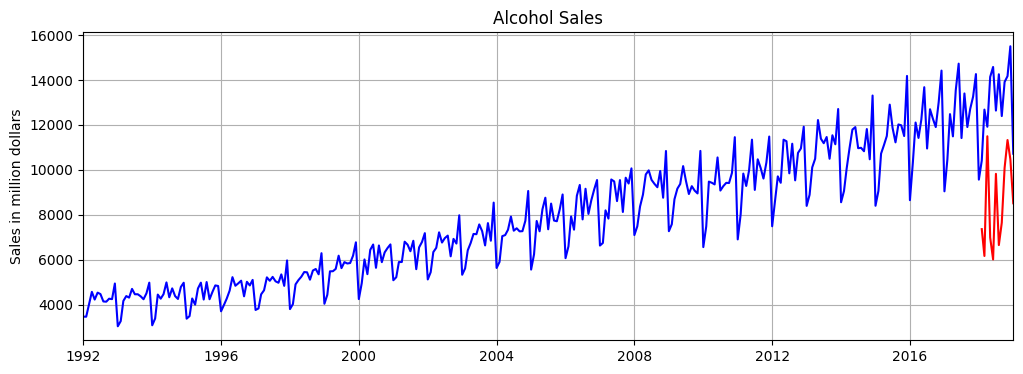

In [26]:
# Plotting

x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
plt.figure(figsize=(12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['Sales'], color='blue')
plt.plot(x, test_predictions_original_scale, color='red')
plt.show()

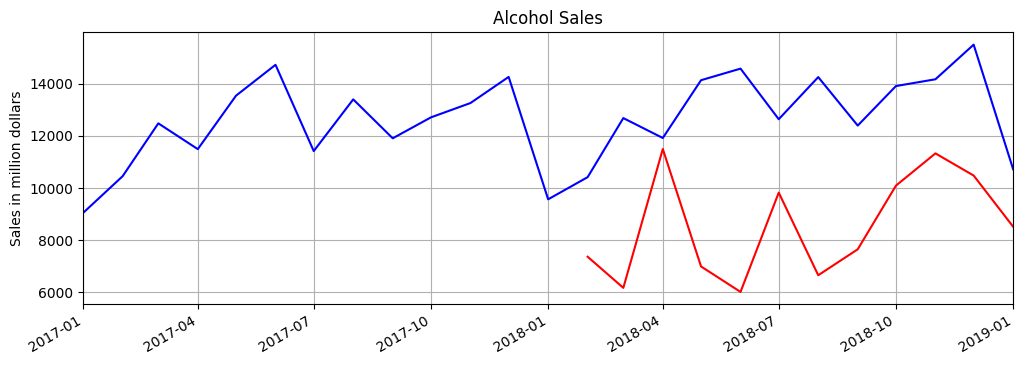

In [28]:
# Zooming the test predictions

fig = plt.figure(figsize=(12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales in million dollars')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

plt.plot(df['Sales']['2017-01-01':], color='blue')
plt.plot(x, test_predictions_original_scale, color='red')
plt.show()